<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/05_TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import numpy as np

In [3]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, median_absolute_error
import pickle

**Read the pickle files**





In [4]:
pathData = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"

In [5]:
with open(pathData + '124766.pk', 'rb') as f:
  df = pickle.load(f)
df = df.sort_values('DATE1')
df.head()

,SLS_CNTR_ID,DATE1,QTY,isSalaryweek,Holiday,AcademicCalendarSemester,isWeekend,isNationalday,isRamadan,isRamadanEnd,...,Category_Cancelled,Category_HomeMade,Category_HomeMadewithVAT,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany
414161,4,2017-12-03,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
414160,1,2017-12-03,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
414149,4,2017-12-05,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
414178,4,2017-12-06,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
414162,1,2017-12-07,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
print("number of records:", len(df))

number of records: 18184


**Train / Test Split**

In [7]:
train = df.loc[df['DATE1'] < '2022-01-01'] # df.index.get_level_values('DATE1').dayofweek == 0
test = df.loc[df['DATE1'] >= '2022-01-01']
print(len(train), ' + ', len(test), ' = ',len(df), ", that is :", f'{len(train)/len(df):0.2%}', ' of data allocated for model training')

14208  +  3976  =  18184 , that is : 78.13%  of data allocated for model training


In [ ]:
# Use this if DATE1 is defined as index
#df.set_index("DATE1", inplace = True)
#train = df.loc[df.index.get_level_values('DATE1') < '2022-01-01'] # df.index.get_level_values('DATE1').dayofweek == 0
#test = df.loc[df.index.get_level_values('DATE1') >= '2022-01-01']
#print(len(train), ' + ', len(test), ' = ',len(df), ", that is :", f'{len(train)/len(df):0.2%}', ' of data allocated for model training')

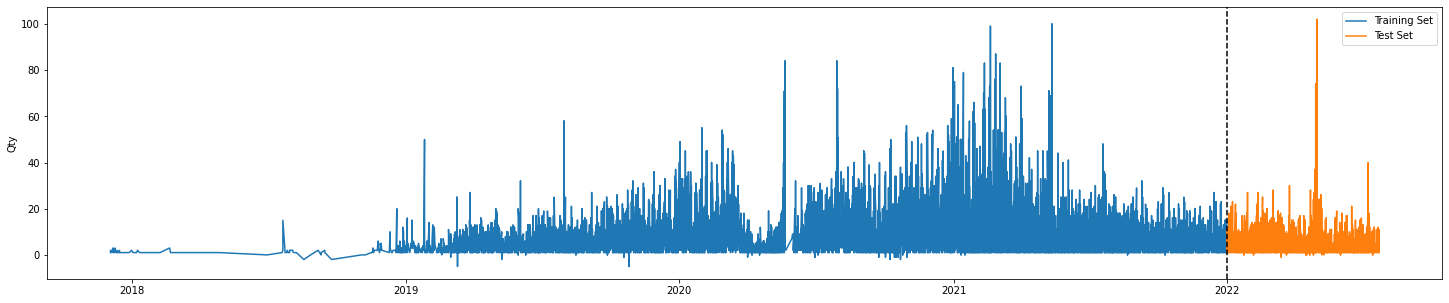

In [8]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train['DATE1'], train['QTY'], label='Training Set')
plt.plot(test['DATE1'], test['QTY'], label='Test Set')
plt.ylabel('Qty')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(pd.Timestamp('2022-01-01'), color='black', ls='--')
plt.show()

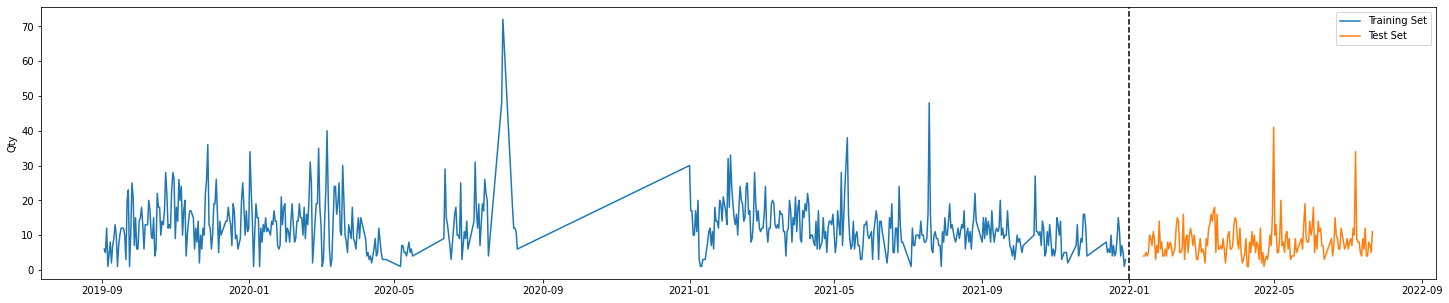

In [9]:
train58 = train.loc[train['SLS_CNTR_ID'] == 58]
test58 = test.loc[test['SLS_CNTR_ID'] == 58]
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train58['DATE1'], train58['QTY'], label='Training Set')
plt.plot(test58['DATE1'], test58['QTY'], label='Test Set')
plt.ylabel('Qty')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(pd.Timestamp('2022-01-01'), color='black', ls='--')
plt.show()

**Create the Model**

In [10]:
#DataFrame.dtypes for data must be int, float or bool, so we are removing 'ITEM_ID' and 'DATE1'
FEATURES = ['SLS_CNTR_ID', 'isSalaryweek', 'AcademicCalendarSemester', 'isWeekend', 'isRamadan', 'isRamadanEnd', 'isEid', 'isNationalday']
TARGET = 'QTY'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
model = xgb.XGBRegressor(base_score=0.05, booster='gbtree', 
                         min_child_weight=1,
                         random_state=5,   
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror', # instead of 'reg:linear' that is deprecated 
                       max_depth=10,
                       learning_rate=0.001)

In [12]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:10.9322	validation_1-rmse:6.17486
[100]	validation_0-rmse:10.2899	validation_1-rmse:5.62807
[200]	validation_0-rmse:9.73177	validation_1-rmse:5.17337
[300]	validation_0-rmse:9.24944	validation_1-rmse:4.80425
[400]	validation_0-rmse:8.83407	validation_1-rmse:4.51301
[500]	validation_0-rmse:8.47798	validation_1-rmse:4.29142
[600]	validation_0-rmse:8.17419	validation_1-rmse:4.13045
[700]	validation_0-rmse:7.91585	validation_1-rmse:4.02137
[800]	validation_0-rmse:7.69715	validation_1-rmse:3.95538
[900]	validation_0-rmse:7.51259	validation_1-rmse:3.92408
[999]	validation_0-rmse:7.35882	validation_1-rmse:3.91932


XGBRegressor(base_score=0.05, early_stopping_rounds=50, learning_rate=0.001,
             max_depth=10, n_estimators=1000, objective='reg:squarederror',
             random_state=5)

In [14]:
test = test.drop(columns=['prediction'])

KeyError: ignored

In [15]:
test['prediction'] = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Model RMSE score**

In [16]:
score = np.sqrt(mean_squared_error(test['QTY'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3.92


In [17]:
explained_variance_score(test['QTY'], test['prediction']) # Best possible score is 1.0, lower values are worse

0.24557428510559354

In [18]:
r2_score(test['QTY'], test['prediction']) # 1.0 perfect, 0 impperfect

0.2452584149697643

In [19]:
median_absolute_error(test['QTY'], test['prediction']) # Best value is zero

1.4576778411865234

**Calculate Error**

Look at the worst and best prediction days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test['DATE1']
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(20)

date
2022-05-01    16.429448
2022-07-08     8.595166
2022-04-30     7.478843
2022-04-29     6.872819
2022-05-03     4.616639
2022-04-28     3.905787
2022-01-28     3.544768
2022-05-07     3.458606
2022-02-11     3.353968
2022-04-22     3.247298
2022-05-05     3.196831
2022-01-01     3.164574
2022-03-31     3.084025
2022-03-13     3.065413
2022-03-15     3.004587
2022-05-04     2.994523
2022-03-11     2.979890
2022-04-26     2.906998
2022-03-25     2.906879
2022-01-12     2.896503
Name: error, dtype: float64

Save the model

In [20]:
with open(pathData + 'model.pk', 'wb') as f:
  pickle.dump(model, f)

**Feature Importance**

In [ ]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d [%s], Score: %.5f' % (i, FEATURES[i], v))
#FEATURES = ['SLS_CNTR_ID', 'isSalaryweek', 'AcademicCalendarSemester', 'isWeekend', 'isRamadan', 'isRamadanEnd', 'isEid', 'isNationalday']

Feature: 0 [SLS_CNTR_ID], Score: 0.89824
Feature: 1 [isSalaryweek], Score: 0.00887
Feature: 2 [AcademicCalendarSemester], Score: 0.00832
Feature: 3 [isWeekend], Score: 0.01089
Feature: 4 [isRamadan], Score: 0.00900
Feature: 5 [isRamadanEnd], Score: 0.06469
Feature: 6 [isEid], Score: 0.00000
Feature: 7 [isNationalday], Score: 0.00000


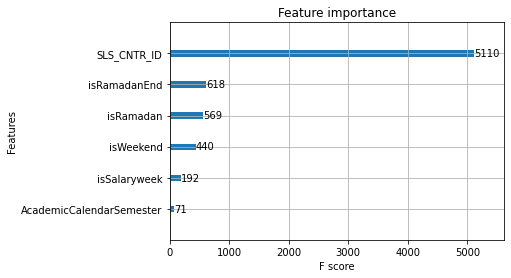

In [ ]:
#from xgboost import XGBRegressor
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.show()

**Forecast on Test**

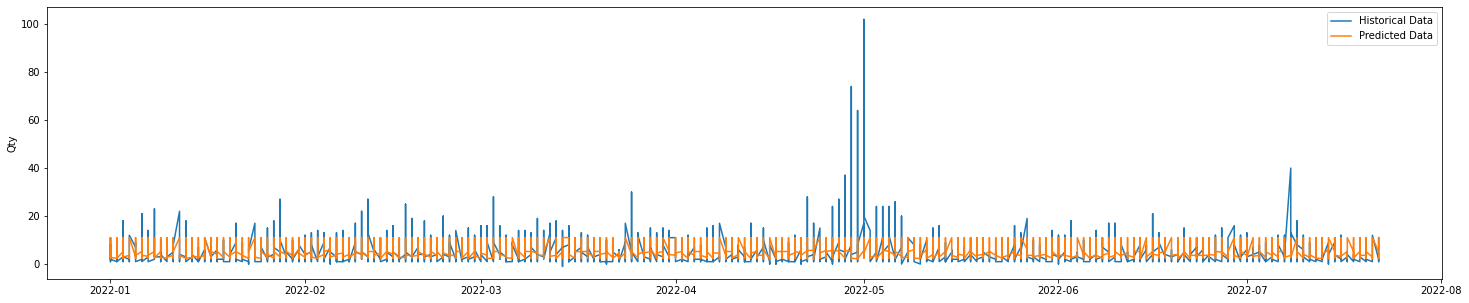

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(test['DATE1'], test['QTY'], label='Historical Data')
plt.plot(test['DATE1'], test['prediction'], label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()

In [ ]:
test

,SLS_CNTR_ID,DATE1,QTY,isSalaryweek,Holiday,AcademicCalendarSemester,isWeekend,isNationalday,isRamadan,isRamadanEnd,...,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany,error,date,prediction
397521,37,2022-01-01,8.0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,2.793313,2022-01-01,5.206687
397520,34,2022-01-01,4.0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1.206687,2022-01-01,5.206687
397519,30,2022-01-01,4.0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0.068982,2022-01-01,4.068982
397518,28,2022-01-01,6.0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1.378710,2022-01-01,4.621290
397517,24,2022-01-01,7.0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1.749791,2022-01-01,5.250209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399333,30,2022-07-22,5.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0.931018,2022-07-22,4.068982
399334,34,2022-07-22,2.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,3.206687,2022-07-22,5.206687
399335,37,2022-07-22,1.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,4.206687,2022-07-22,5.206687
399324,4,2022-07-22,3.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0.629320,2022-07-22,3.629320


In [ ]:
#use this if index is used
#span = test.loc[(test.index.get_level_values('DATE1') >= '2022-04-01') & (test.index.get_level_values('DATE1') < '2022-04-12') &
#                (test['SLS_CNTR_ID'] == 58)]

In [ ]:
span = test.loc[(test['DATE1'] >= '2022-04-15') & (test['DATE1'] < '2022-05-15')]

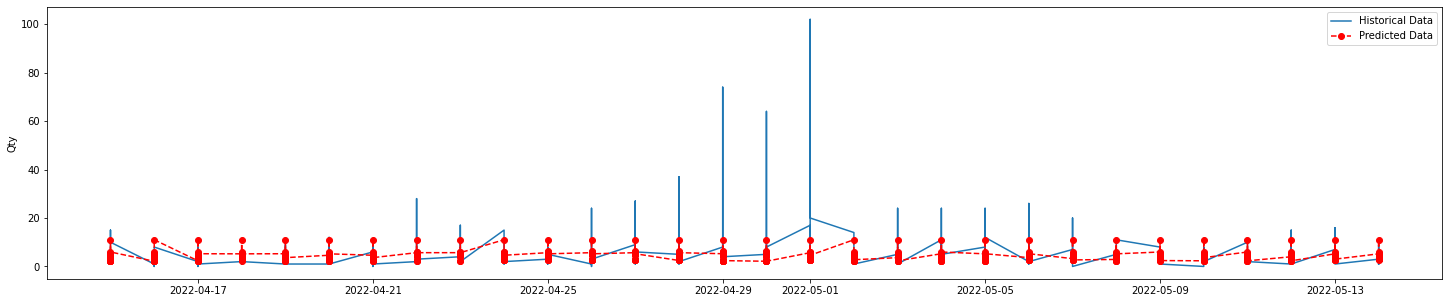

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(span['DATE1'], span['QTY'], label='Historical Data')
plt.plot(span['DATE1'], span['prediction'], marker='o', linestyle='--', color='r', label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()

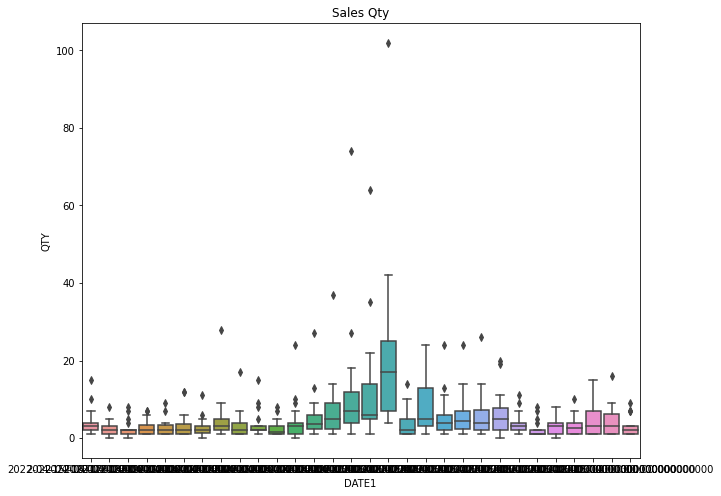

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=span, x='DATE1', y='QTY')
ax.set_title('Sales Qty')
plt.show()

In [ ]:
span = test.loc[(test['DATE1'] >= '2022-04-15') & (test['DATE1'] < '2022-04-20')]

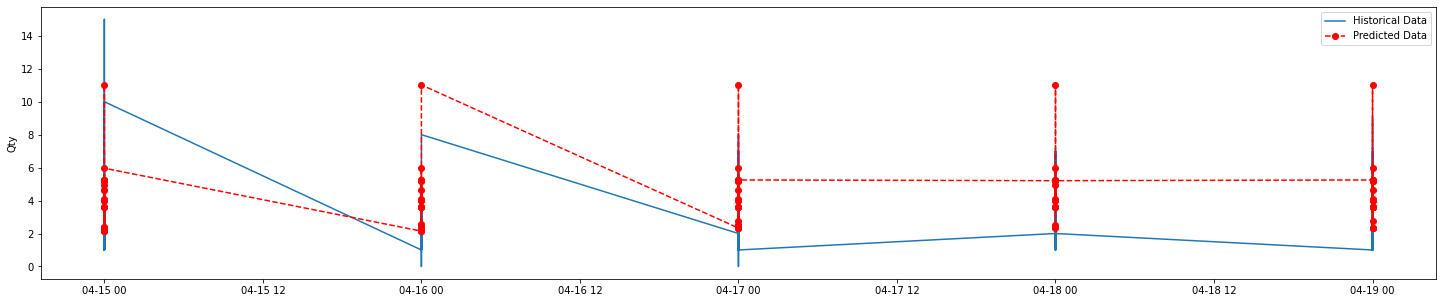

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(span['DATE1'], span['QTY'], label='Historical Data')
plt.plot(span['DATE1'], span['prediction'], marker='o', linestyle='--', color='r', label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()

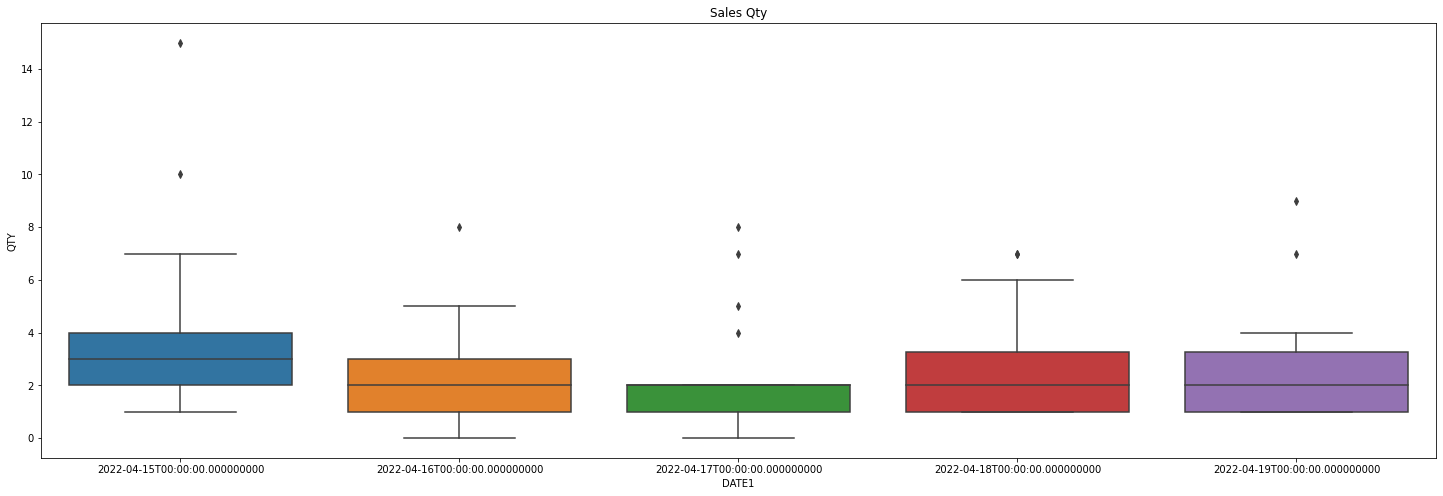

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(data=span, x='DATE1', y='QTY')
ax.set_title('Sales Qty')
plt.show()

In [ ]:
span = test.loc[(test['DATE1'] >= '2022-04-15') & (test['DATE1'] < '2022-05-15') & (test['SLS_CNTR_ID'] == 58)]

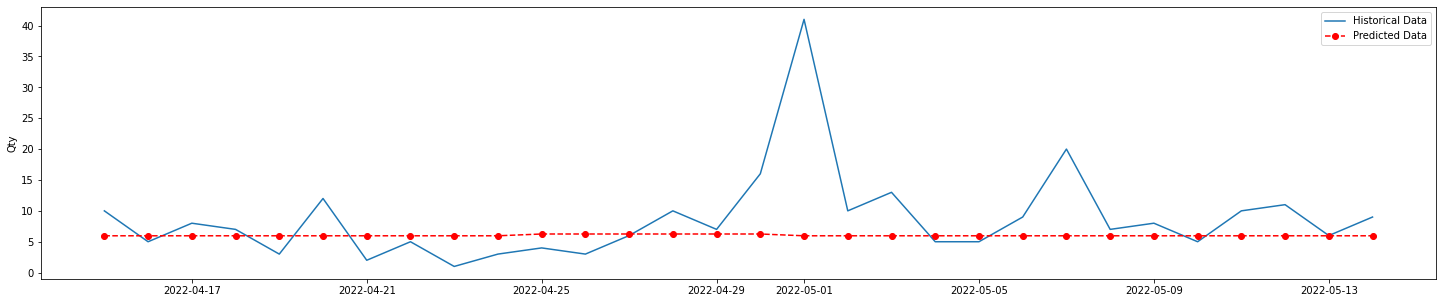

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(span['DATE1'], span['QTY'], label='Historical Data')
plt.plot(span['DATE1'], span['prediction'], marker='o', linestyle='--', color='r', label='Predicted Data')
plt.ylabel('Qty')
plt.legend(['Historical Data', 'Predicted Data'])
plt.show()